**DATA PREPARATION**



*   Import Packages



In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math



*   Read data from a CSV file



In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VLO.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,92.190002,93.139999,91.709999,92.800003,72.733238,3582900
1,2018-01-03,92.580002,93.470001,92.500000,93.290001,73.117294,3057600
2,2018-01-04,93.410004,93.620003,92.639999,93.589996,73.352425,2977000
3,2018-01-05,93.599998,94.300003,93.430000,94.029999,73.697281,2973800
4,2018-01-08,94.129997,94.370003,93.400002,94.220001,73.846207,2493400




*   Visualize the stock price history


Text(0, 0.5, 'Prices ($)')

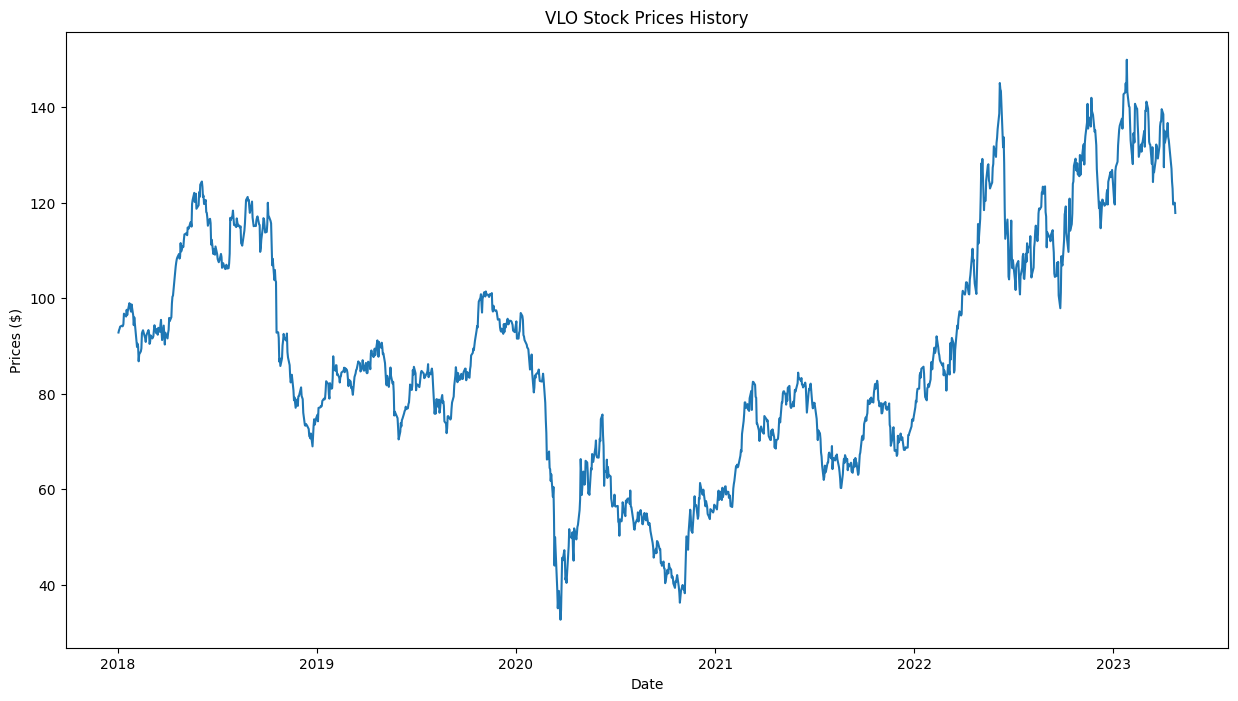

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title('VLO Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**DATA PREPROCESSING**



*   Import Packages



In [5]:
from numpy import linalg as la
import statistics as stat
from scipy.special import ndtri
from scipy.stats import norm
import random
from sklearn.metrics import mean_squared_error



*   Split data into train, test, and validation sets with a ratio of 7:2:1



In [6]:
close_prices = data['Close']
values = close_prices.values

train_size = int(len(close_prices) * 0.7)
test_size = int(len(close_prices) * 0.2)
val_size = len(close_prices) - train_size - test_size

train_data = values[:train_size]
test_data = values[train_size:train_size+test_size]
val_data = values[train_size+test_size:]

**MCMC**

In [7]:
mu, sig, N = 1.1, 1, 100000
pts = []

*In a normal distribution, **mu** represents the mean, **sig** represents
the standard deviation, and **N** represents the number of samples.*

In [8]:
def q(x):
    return (1 / (math.sqrt(2 * math.pi * sig ** 2))) * (math.e ** (-((x - mu) ** 2) / (2 * sig ** 2)))

def MCMC(n):
    r = np.zeros(1)
    p = q(r[0])
    pts = []

    for i in range(N):
        rn = r + np.random.uniform(-1, 1)
        pn = q(rn[0])
        if pn >= p:
            p = pn
            r = rn
        else:
            u = np.random.rand()
            if u < pn / p:
                p = pn
                r = rn
        pts.append(r)

    pts = random.sample(pts, len(pts))
    pts = np.array(pts)

    return pts

In [9]:
stock_pred = []

maturnity = 1
volatility = 0.25
risk_free = 0.1
timestep = 1
steps = test_size + val_size
delta_t = maturnity / steps
i = 0
stock_pred.append(train_data[-1])
while timestep < steps:
  stock_price = stock_pred[-i]
  time_exp = maturnity - delta_t * timestep
  # Generate z_t using MCMC method
  pts = MCMC(N)
  stock_price = stock_price * math.exp(((risk_free - 0.5 * (math.pow(volatility, 2))) * delta_t + volatility * math.sqrt(delta_t) * pts[timestep + 5]))
  stock_pred.append(stock_price)
  i = i + 1
  timestep = timestep + 1



*   Evaluate the algorithm's accuracy using RMSE, MAPE, MDA



In [10]:
test_data = np.array(test_data)
val_data = np.array(val_data)

In [11]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((val_data - stock_pred[test_size:]) ** 2))
test_rmse = np.sqrt(np.mean((test_data - stock_pred[:test_size]) ** 2))
valid_mape = calculate_mape(val_data, stock_pred[test_size:])
test_mape = calculate_mape(test_data, stock_pred[:test_size])
valid_mda = calculate_mda(val_data, stock_pred[test_size:])
test_mda = calculate_mda(test_data, stock_pred[:test_size])

# In kết quả
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 64.23463145928703
Testing RMSE: 35.98422694455109
Validation MAPE: 48.717326225979626
Testing MAPE: 28.292891746316094
Validation MDA: 46.26865671641791
Testing MDA: 50.37593984962406


**VISUALIZATION OF PREDICTIONS**



*   Plot 1



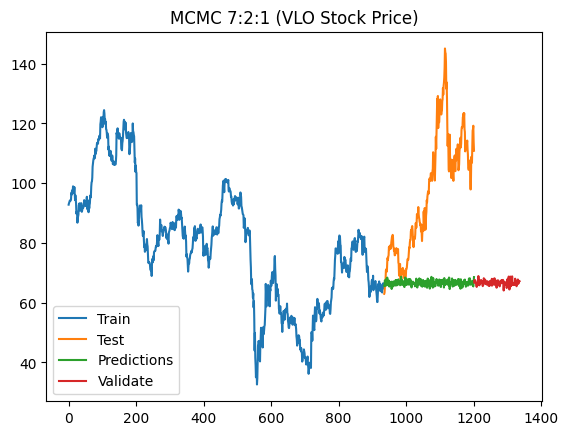

In [12]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data)

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=len(close_prices), step=1)

plt.plot(test_data_index,test_data)
plt.plot(test_data_index,stock_pred[:test_size])

# plt.plot(val_data_index,val_data)
plt.plot(val_data_index,stock_pred[test_size:])

plt.title('MCMC 7:2:1 (VLO Stock Price)')
plt.legend(['Train','Test','Predictions', 'Validate'])
plt.show()



*   Plot 2



In [13]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=train_data, mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=test_data, mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=stock_pred[:test_size], mode='lines+markers', marker=dict(size=4), name='Predictions', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=stock_pred[test_size:], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'MCMC 7:2:1 (VLO Stock Price)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()